# Setup

In [3]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png"))
options(jupyter.plot_scale = 1.5)
options(warn = -1)
require("pacman")
pacman::p_load(tidyverse, lubridate, zoo, ggpubr, ggfortify, forecast)

source('../Scripts/ReadData.R')
source('../Scripts/ModelSelection.R')
source('../Scripts/ResidualAnalysis.R')
source('../Scripts/Forecasting.R')

# Training S/ARIMA Model


## ARIMA

In [4]:
homeownership <- read_homeownership()

test_split <- 4
train <- head(homeownership, -test_split)
test <- tail(homeownership, test_split)
arima_comp <- find_best_arima(train$Value, 0:5, 0:2, 0:5)
head(arima_comp)

,p,d,q,AICC
,<int>,<int>,<int>,<dbl>
1,4,1,4,84.58706
2,5,2,5,91.42055
3,5,2,1,92.86359
4,3,1,3,93.41243
5,5,1,2,93.63021
6,2,1,2,93.79914



	Box-Ljung test

data:  residuals(model)
X-squared = 2.2211, df = 1, p-value = 0.1361


	Box-Ljung test

data:  residuals(model)^2
X-squared = 3.4557, df = 1, p-value = 0.06303



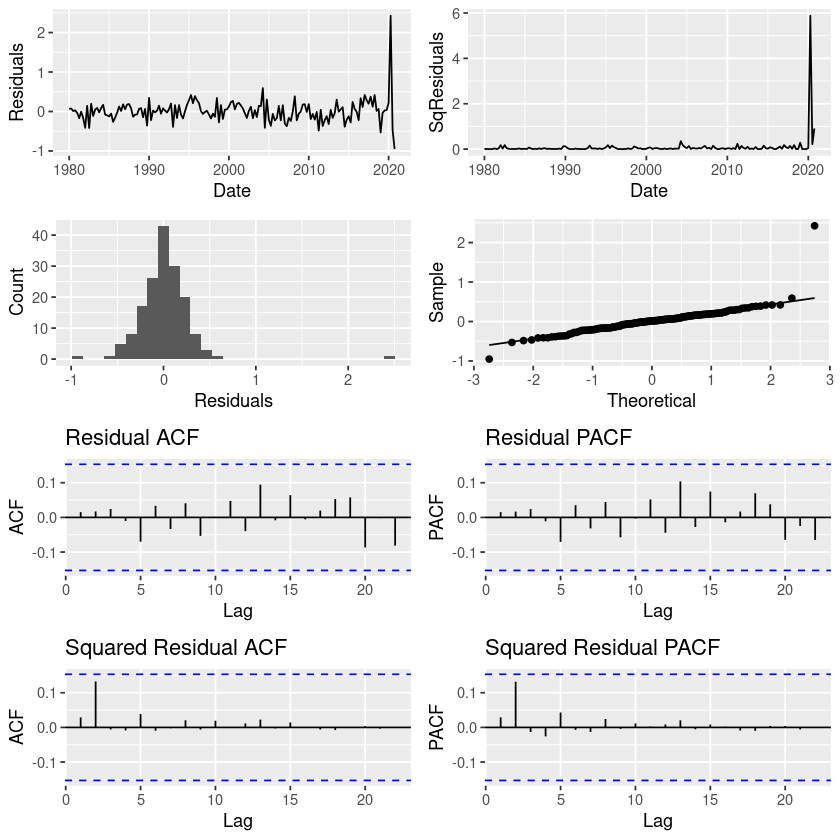

In [5]:
best_order <- arima_comp[1,1:3] %>% as.numeric
arima_model <- arima(train$Value, order = best_order, method = "ML")
residual_analysis(arima_model, train$Date)
box_tests(arima_model, best_order[1] + best_order[3])

## SARIMA

In [6]:
seasonal_factors = list(order = c(1,0,1), period = 4)
sarima_comp <- find_best_arima(train$Value, 0:5, 0:2, 0:5, seasonal_factors)
head(sarima_comp)

,p,d,q,AICC
,<int>,<int>,<int>,<dbl>
1,2,1,5,91.86538
2,3,1,4,92.88787
3,4,1,3,93.54328
4,2,1,2,94.49545
5,5,1,0,94.76491
6,4,1,2,94.77973



	Box-Ljung test

data:  residuals(model)
X-squared = 2.5901, df = 1, p-value = 0.1075


	Box-Ljung test

data:  residuals(model)^2
X-squared = 11.949, df = 1, p-value = 0.0005468



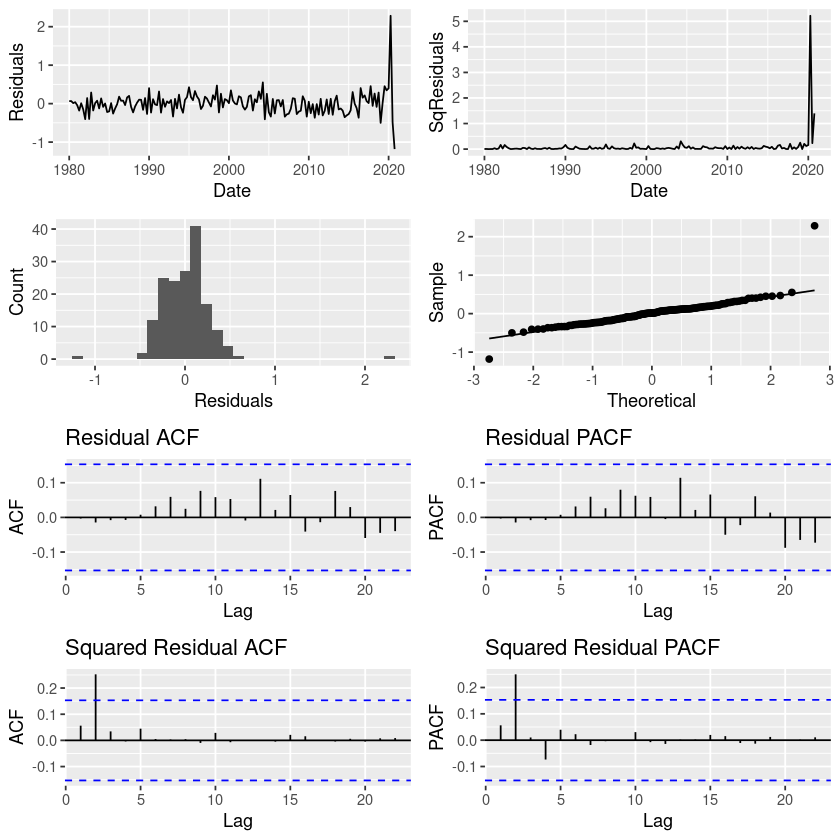

In [7]:
best_order <- sarima_comp[1,1:3] %>% as.numeric
sarima_model <- arima(train$Value, order = best_order, seasonal = seasonal_factors, method = "ML")
residual_analysis(sarima_model, train$Date)
box_tests(sarima_model, best_order[1] + best_order[3] + 2)

# Cleaning Outliers

In [8]:
outliers <- tsoutliers(homeownership$Value)
outliers
cleaned_homeownership <- homeownership
cleaned_homeownership$Value[outliers$index] <- outliers$replacements
cleaned_train <- head(cleaned_homeownership, -test_split)
cleaned_test <- tail(cleaned_homeownership, test_split)

$index
[1] 162 163

$replacements
[1] 65.43333 65.56667

In [9]:
clean_arima_comp <- find_best_arima(cleaned_train$Value, 0:5, 0:2, 0:5)
head(clean_arima_comp)
clean_sarima_comp <- find_best_arima(cleaned_train$Value, 0:5, 0:2, 0:5, seasonal_factors)
head(clean_sarima_comp)

,p,d,q,AICC
,<int>,<int>,<int>,<dbl>
1,4,1,5,-76.35727
2,5,1,4,-76.35671
3,5,1,5,-75.04156
4,3,1,3,-73.91852
5,3,1,4,-71.71477
6,4,1,3,-71.71368


,p,d,q,AICC
,<int>,<int>,<int>,<dbl>
1,4,1,5,-78.86390
2,5,1,5,-77.64680
3,3,1,3,-75.72996
4,2,0,2,-75.58924
5,5,0,0,-75.38850
6,1,1,2,-74.35416


# Cleaned Models

## ARIMA


	Box-Ljung test

data:  residuals(model)
X-squared = 2.7239, df = 1, p-value = 0.09886


	Box-Ljung test

data:  residuals(model)^2
X-squared = 10.342, df = 1, p-value = 0.0013



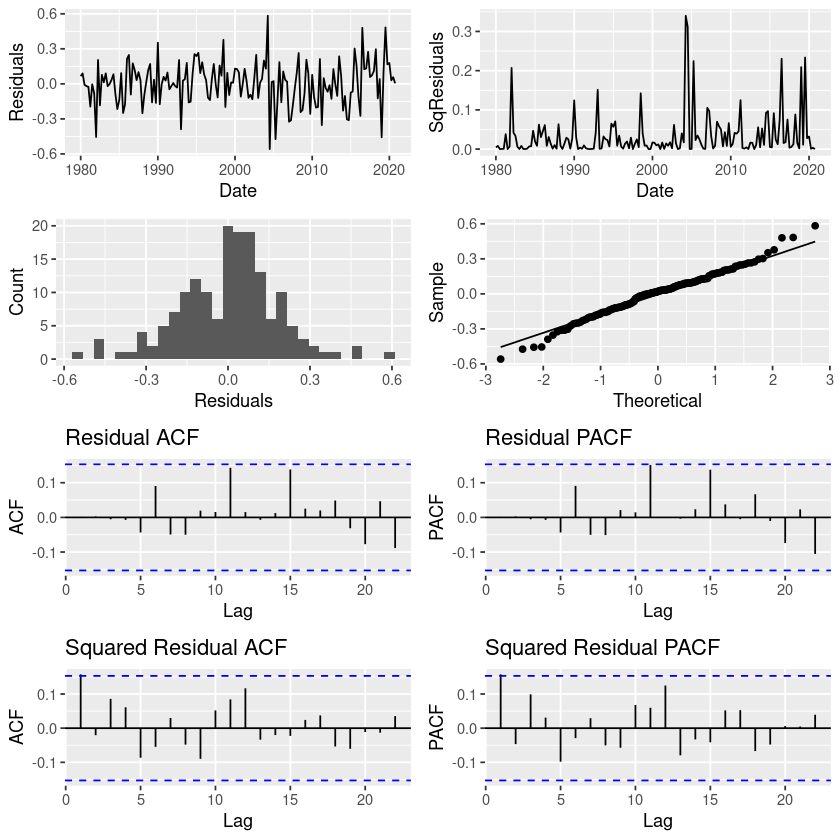

In [10]:
best_order <- clean_arima_comp[1,1:3] %>% as.numeric
cleaned_arima_model <- arima(cleaned_train$Value, order = best_order, method = "ML")
residual_analysis(cleaned_arima_model, cleaned_train$Date)
box_tests(cleaned_arima_model, best_order[1] + best_order[3])

## SARIMA


	Box-Ljung test

data:  residuals(model)
X-squared = 8.0035, df = 1, p-value = 0.004669


	Box-Ljung test

data:  residuals(model)^2
X-squared = 10.132, df = 1, p-value = 0.001457



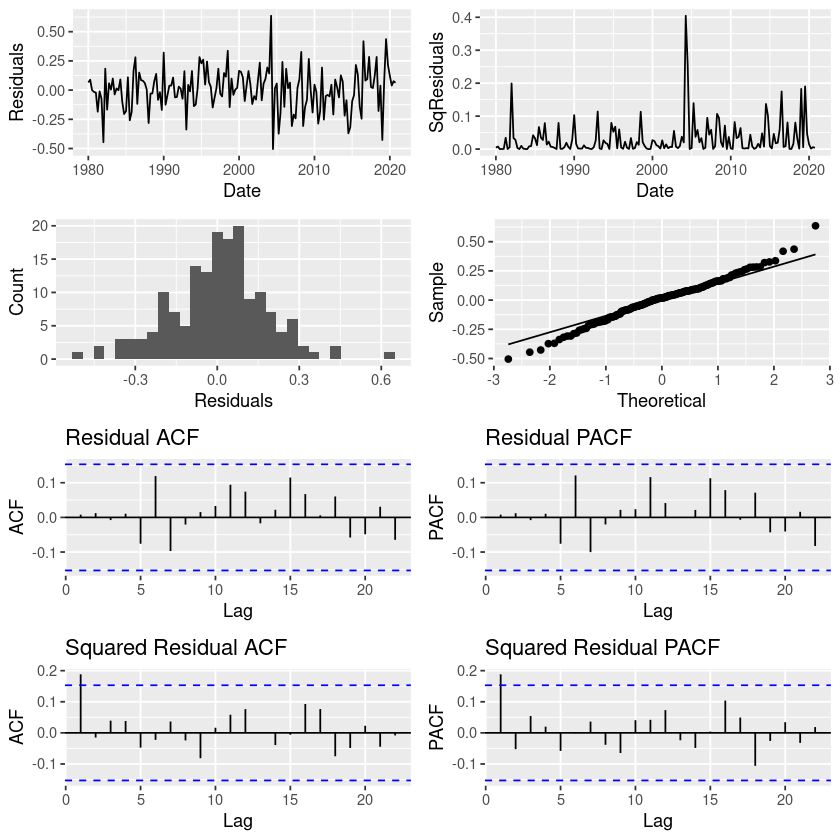

In [11]:
best_order <- clean_sarima_comp[1,1:3] %>% as.numeric
cleaned_sarima_model <- arima(cleaned_train$Value, order = best_order, seasonal = seasonal_factors, method = "ML")
residual_analysis(cleaned_sarima_model, cleaned_train$Date)
box_tests(cleaned_sarima_model, best_order[1] + best_order[3] + 2)

# Forecasting

## Raw Data Forecasting

PM =  231.5413

,ME,RMSE,MAE,MPE,MAPE
Test set,-1.474622,1.521648,1.474622,-2.251613,2.251613


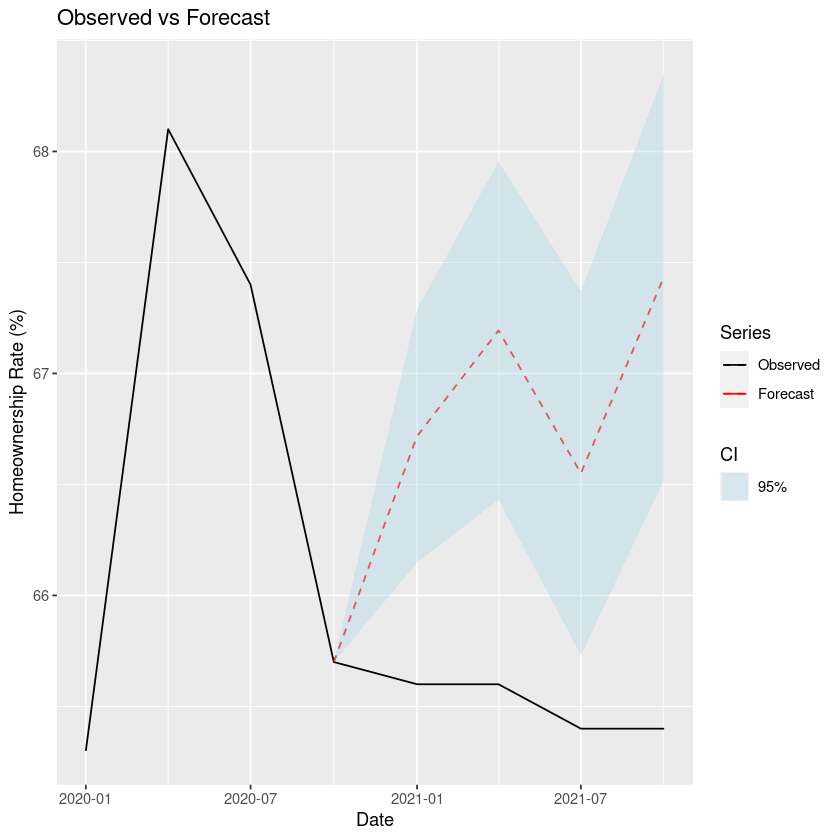

In [12]:
fc <- forecast_arima(arima_model, homeownership$Date, test$Value, 4, 95,
                    y_lab = "Homeownership Rate (%)")
fc$plot
fc_data <- tail(fc$data, 4)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

PM =  151.6417

,ME,RMSE,MAE,MPE,MAPE
Test set,-1.0259,1.231429,1.101266,-1.56544,1.680677


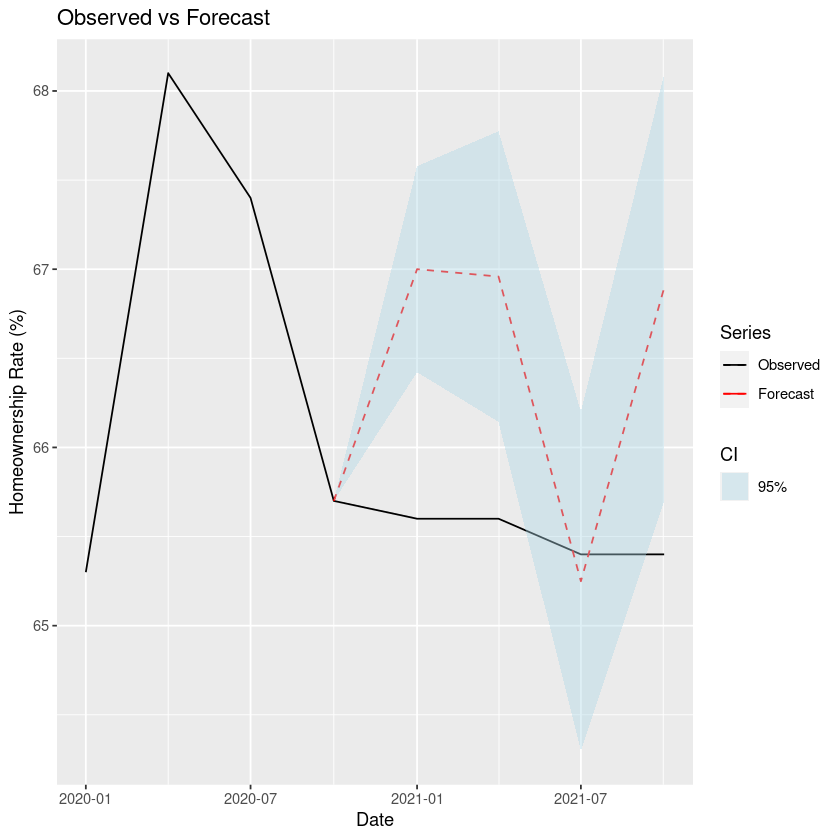

In [13]:
fc <- forecast_arima(sarima_model, homeownership$Date, test$Value, 4, 95,
                    y_lab = "Homeownership Rate (%)")
fc$plot
fc_data <- tail(fc$data, 4)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

## Cleaned Data Forecasting

PM =  25.68014

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.4650974,0.5067557,0.4650974,-0.7105283,0.7105283


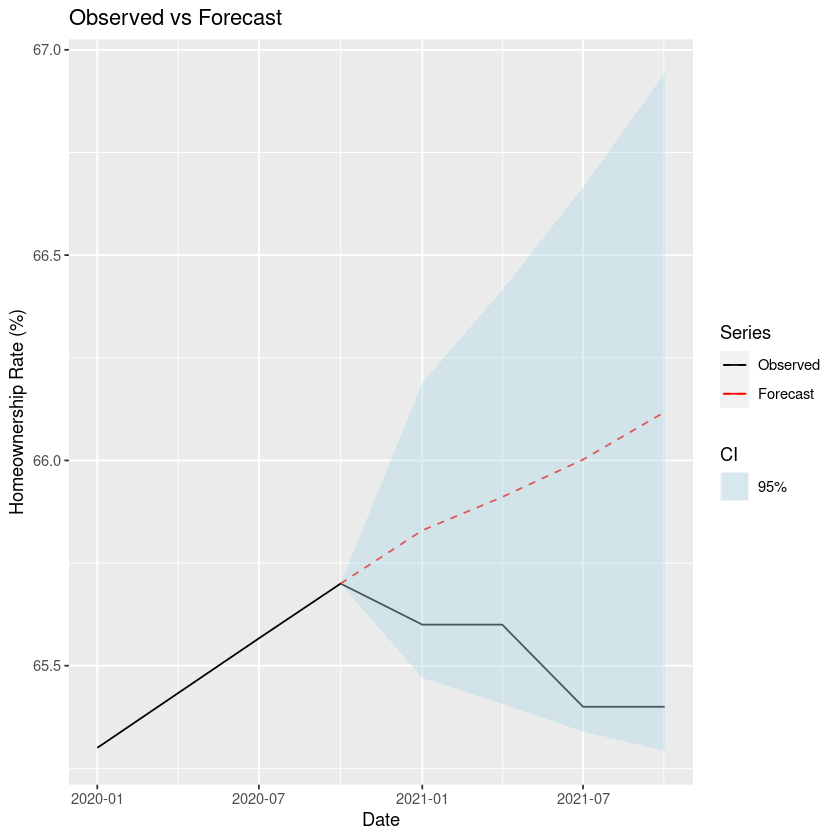

In [14]:
fc <- forecast_arima(cleaned_arima_model, homeownership$Date, test$Value, 4, 95,
                    y_lab = "Homeownership Rate (%)")
fc$plot
fc_data <- tail(fc$data, 4)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

PM =  28.70402

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.5087916,0.5357613,0.5087916,-0.777162,0.777162


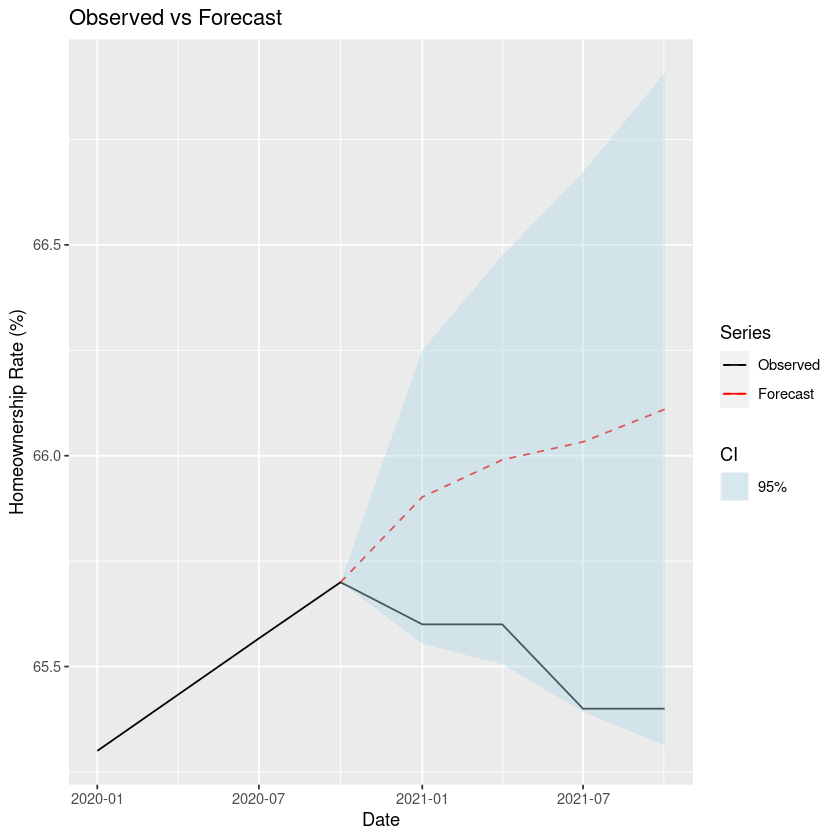

In [15]:
fc <- forecast_arima(cleaned_sarima_model, homeownership$Date, test$Value, 4, 95,
                    y_lab = "Homeownership Rate (%)")
fc$plot
fc_data <- tail(fc$data, 4)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)